# Setup

In [1]:
import sys
sys.path.append("../")

import random

import torch
from torchvision.transforms import Resize

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable


from Dataset.dataset import *
from Dataset.data_generation import ArrhythmiaLabels
from Utils.benchmarking import *
from Utils.model_loading import *
from Utils.display import *
from Utils.classification import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("whitegrid")
sns.set_palette("husl")

Using cuda:0


# Benchmarks
Evaluate all models and store their stats (accuracy, latency, ...) in a json file. Then load the stats from that json to use for comparisons.

Note: Some benchmarks need to be updated. Some of the plotting functions were refactored and have not been updated here.

## Benchmark All Models

In [2]:
json_path = "../model_stats.json"

# Main models
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 128,
    transform  = Resize((152, 152), antialias=None)
)

models = {
    "alexnet":            "AlexNet",
    "vgg16_bn":           "VGG16",
    "vgg16_bn_custom":    "VGG16 Custom 152",
    "resnet18":           "ResNet18", 
    "mobilenet_v3":       "MobileNetV3 Large", 
    "mobilenet_v3_small": "MobileNetV3 Small", 
    "ofa_595M":           "OFA 595M", 
    "ofa_pixel1_20":      "OFA Pixel 1 20ms",
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    stat = benchmark_model(loaded_model, dataloader["test"], name)
    add_model_stat_to_json(json_path, stat)
    del loaded_model

# MobileNetV3 Small resolution analysis models
resolutions = [80, 104, 128, 152, 176, 200, 224]
for r in resolutions:
    dataloader = build_dataloader(
        train_path = "Data/mitbih_mif_train_small.h5",
        test_path  = "Data/mitbih_mif_test.h5",
        batch_size = 128,
        transform  = Resize((r, r), antialias=None)
    )
    model = load_model_from_pretrained("mobilenet_v3_small", f"Pretrained/MobileNetV3-Small/mobilenet_v3_small_ecg_ep15_i{r}.pth", 5)
    stat = benchmark_model(model, dataloader["test"], f"MobileNetV3 Small - Resolution {r}")
    add_model_stat_to_json(json_path, stat)
    del model

# Pruning
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 32,
    transform  = Resize((152, 152), antialias=None)
)

pruning_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
for pr in pruning_ratios:
    p_model = load_vgg_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_p{pr}.pth", pr, torch.rand((1, 3, 152, 152)))
    p_stat = benchmark_model(p_model, dataloader["test"], f"VGG16 - Layer Pruned {pr}")
    add_model_stat_to_json(json_path, p_stat)
    del p_model

    g_model = torch.load(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_g{pr}.pth")
    g_stat = benchmark_model(g_model, dataloader["test"], f"VGG16 - Global Pruned {pr}")
    add_model_stat_to_json(json_path, g_stat)
    del g_model

# Pruned VGG custom
p_model = load_vgg_custom_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_custom_ecg_ep30_i152_p0.8.pth", 0.8, torch.rand((1, 3, 152, 152)))
p_stat = benchmark_model(p_model, dataloader["test"], f"VGG16 Custom 152 - Layer Pruned 0.8")
add_model_stat_to_json(json_path, p_stat)
del p_model

[INFO]: Benchmarking model AlexNet
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for AlexNet finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model ResNet18
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for ResNet18 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Large
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Large finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model OFA 595M
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for OFA 595M finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model OFA Pixel 1 20ms
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for OFA Pixel 1 20ms finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 80
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 80 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 104
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 104 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 128
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 128 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 152
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 152 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 176
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 176 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 200
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 200 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model MobileNetV3 Small - Resolution 224
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for MobileNetV3 Small - Resolution 224 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.5
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.5 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.5
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.5 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.6
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.6 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.6
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.6 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.7
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.7 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.7
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.7 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.8
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.8 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.8
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.8 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Layer Pruned 0.9
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Layer Pruned 0.9 finished
[INFO]: Adding model stat to model_stats.json
[INFO]: Benchmarking model VGG16 - Global Pruned 0.9
[INFO]: 	Getting model params and MACs
[INFO]: 	Measuring latency
[INFO]: 	Evaluating


[INFO]: Benchmarking for VGG16 - Global Pruned 0.9 finished
[INFO]: Adding model stat to model_stats.json


In [2]:
# Quantized models ran through TensorRT engine
from Quantization.benchmark_trt import benchmark_model_trt

json_path = "../model_stats.json"

dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 1,
    transform  = Resize((152, 152), antialias=None)
)

models = {
    "resnet18": [
        ("ResNet18 - TRT FP32", "fp32"),
        ("ResNet18 - TRT FP16", "fp16"),
    ],
    "mobilenet_v3_small": [
        ("MobileNetV3 Small - TRT FP32", "fp32"),
        ("MobileNetV3 Small - TRT FP16", "fp16"),
    ]
}

for model, precisions in models.items():
    for name, precision in precisions:
        engine_path = f"Quantization/Engine/{model}_ecg_ep50_i152_{precision}.engine"
        stat = benchmark_model_trt(engine_path, dataloader["test"], name)
        add_model_stat_to_json(json_path, stat)

[I]: Benchmarking TensorRT model ResNet18 - TRT FP32 from Quantization/Engine/resnet18_ecg_ep50_i152_fp32.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for ResNet18 - TRT FP32 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model ResNet18 - TRT FP16 from Quantization/Engine/resnet18_ecg_ep50_i152_fp16.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for ResNet18 - TRT FP16 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model MobileNetV3 Small - TRT FP32 from Quantization/Engine/mobilenet_v3_small_ecg_ep50_i152_fp32.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for MobileNetV3 Small - TRT FP32 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking TensorRT model MobileNetV3 Small - TRT FP16 from Quantization/Engine/mobilenet_v3_small_ecg_ep50_i152_fp16.engine
[I]: 	Evaluating


[I]: 	Measuring latency
[I]: Benchmark for MobileNetV3 Small - TRT FP16 finished
[I]: Adding model stat to model_stats.json


In [ ]:
# Pruned VGG

from Quantization.benchmark_trt import benchmark_model_trt
json_path = "../model_stats.json"

dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 1,
    transform  = Resize((152, 152), antialias=None)
)

# engine_path = f"Quantization/Engine/vgg16_bn_custom_ecg_ep30_i152_p0.8_fp16.engine"
# stat = benchmark_model_trt(engine_path, dataloader["test"], "VGG16 Custom 152 - Layer Pruned 0.8 - TRT FP16")
# add_model_stat_to_json(json_path, stat)

engine_path = f"Quantization/Engine/vgg16_bn_custom_ecg_ep30_i152_p0.8_int8_max.engine"
stat = benchmark_model_trt(engine_path, dataloader["test"], "VGG16 Custom 152 - Layer Pruned 0.8 - TRT INT8")
add_model_stat_to_json(json_path, stat)

In [2]:
# Half precision models without TensorRT

json_path = "../model_stats.json"

dataloader = build_dataloader(
    train_path     = "Data/mitbih_mif_train_small.h5",
    test_path      = "Data/mitbih_mif_test.h5",
    batch_size     = 128,
    transform      = Resize((152, 152), antialias=None),
    half_precision = True
)

models = {
    "resnet18":           "ResNet18 - FP16", 
    "mobilenet_v3_small": "MobileNetV3 Small - FP16", 
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    stat = benchmark_model(loaded_model.to(torch.float16), dataloader["test"], name, no_latency=True)
    add_model_stat_to_json(json_path, stat)
    del loaded_model

[I]: Benchmarking model ResNet18 - FP16
[I]: 	Getting model params and MACs
[I]: 	Latency measurement skipped
[I]: 	Evaluating


[I]: Benchmarking for ResNet18 - FP16 finished
[I]: Adding model stat to model_stats.json
[I]: Benchmarking model MobileNetV3 Small - FP16
[I]: 	Getting model params and MACs
[I]: 	Latency measurement skipped
[I]: 	Evaluating


[I]: Benchmarking for MobileNetV3 Small - FP16 finished
[I]: Adding model stat to model_stats.json


In [4]:
# GPU latency without TensorRT
json_path = "../model_stats.json"


# Half precision. For now, manually replace the latency in the json file
models = {
    "resnet18":           "ResNet18 - FP16", 
    "mobilenet_v3_small": "MobileNetV3 Small - FP16", 
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152)).to(torch.float16)

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model.to(torch.float16), dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)
    print(model_stat)

    del loaded_model


# Full precision
models = {
    "resnet18":           "ResNet18", 
    "mobilenet_v3_small": "MobileNetV3 Small", 
    "vgg16_bn_custom":    "VGG16 Custom 152"
}

for model, name in models.items():
    loaded_model = load_model_from_pretrained(model, f"Pretrained/{model}_ecg_ep50_i152.pth", 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152))

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)

    model_stat.name = f"{name} - FP32"
    add_model_stat_to_json(json_path, model_stat)

    del loaded_model

# Pruned VGG custom
models = {
    "vgg16_bn_custom": "VGG16 Custom 152 - Layer Pruned 0.8"
}

for model, name in models.items():
    loaded_model = load_vgg_custom_from_pruned(f"Pretrained/VGG-Pruned/{model}_ecg_ep30_i152_p0.8.pth", 0.8, torch.rand((1, 3, 152, 152)), 5)
    model_stat   = get_model_stats_from_json(json_path, [name])[0]

    dummy_input  = torch.rand((1, 3, 152, 152))

    latencies = []
    for _ in range(0, 10):
        latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
    model_stat.latency = sum(latencies) / len(latencies)

    model_stat.name = f"{name} - FP32"
    add_model_stat_to_json(json_path, model_stat)

    del loaded_model

ModelStats(name='ResNet18 - FP16', macs=880630784.0, params=11179077, latency=0.0034244098901748655, accuracy=98.38754272460938)
ModelStats(name='MobileNetV3 Small - FP16', macs=30815864.0, params=1522981, latency=0.007043296384811401, accuracy=97.92617797851562)
[I]: Adding model stat to model_stats.json
[I]: Adding model stat to model_stats.json


In [14]:
# Full precision VGG 224
json_path = "../model_stats.json"

dataloader = build_dataloader(
    train_path     = "Data/mitbih_mif_train_small.h5",
    test_path      = "Data/mitbih_mif_test.h5",
    batch_size     = 32,
    transform      = Resize((224, 224), antialias=None),
)

# Benchmark
loaded_model = load_model_from_pretrained("vgg16_bn", f"Pretrained/vgg16_bn_ecg_ep50_i224.pth", 5)
model_stat   = benchmark_model(loaded_model, dataloader["test"], "VGG16 - Resolution 224")
add_model_stat_to_json(json_path, model_stat)

# GPU Latency
model_stat  = get_model_stats_from_json(json_path, ["VGG16 - Resolution 224"])[0]
dummy_input = torch.rand((1, 3, 224, 224))

latencies = []
for _ in range(0, 10):
    latencies.append(measure_latency(loaded_model, dummy_input, test_device=device))
model_stat.latency = sum(latencies) / len(latencies)

model_stat.name = f"VGG16 - Resolution 224 - FP32"
add_model_stat_to_json(json_path, model_stat)

del loaded_model

[I]: Benchmarking model VGG16 - Resolution 224
[I]: 	Getting model params and MACs
[I]: 	Measuring latency
[I]: 	Evaluating


[I]: Benchmarking for VGG16 - Resolution 224 finished
[I]: Adding model stat to model_stats.json
[I]: Adding model stat to model_stats.json


## Size of Training Data

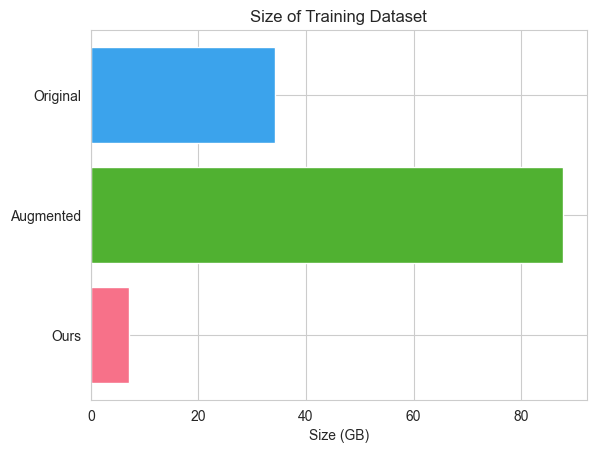

In [10]:
# Size of training data

original_data = get_dataset_size(image_size=187, channels=3, num_images=87554, data_width=32)
paper_data    = get_dataset_size(image_size=227, channels=3, num_images=152471, data_width=32)
my_data       = get_dataset_size(image_size=152, channels=3, num_images=27554, data_width=32)


compare_single_values(
    [original_data, paper_data, my_data],
    ["Original", "Augmented", "Ours"],
    axis  = "Size (GB)",
    title = "Size of Training Dataset",
)

## Model Comparison

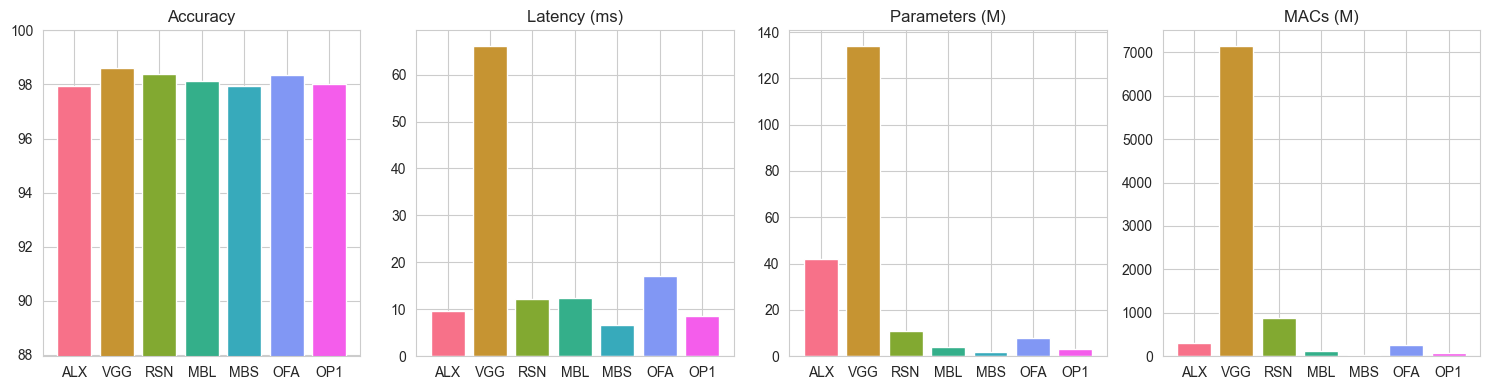

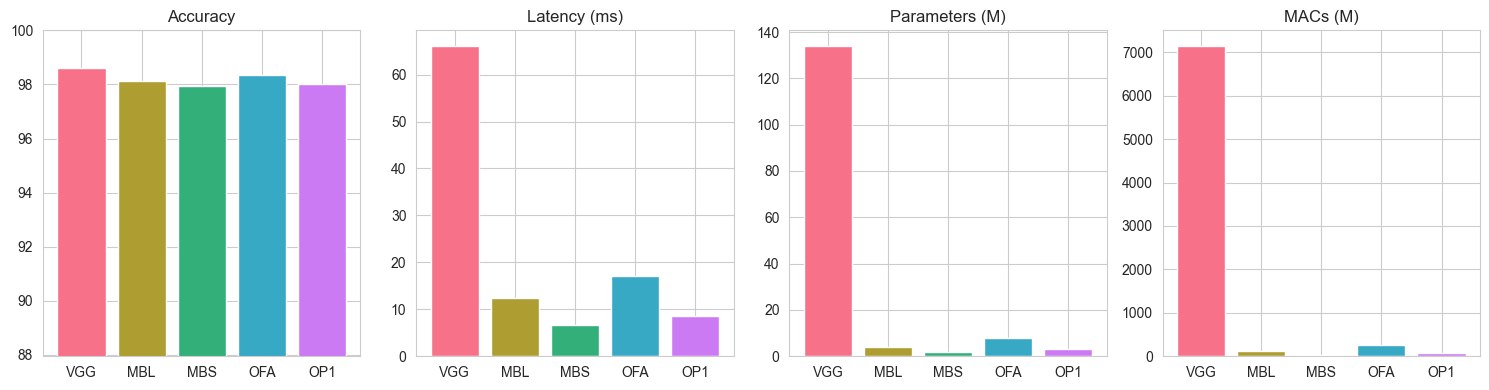

In [5]:
models = {
    "AlexNet":           "ALX",
    "ResNet18":          "RSN",
    "VGG16":             "VGG", 
    "MobileNetV3 Large": "MBL", 
    "MobileNetV3 Small": "MBS", 
    "OFA 595M":          "OFA", 
    "OFA Pixel 1 20ms":  "OP1"
}

stats = get_model_stats_from_json("../model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, fig_size=(15, 4))
compare_models([stats[1], stats[3], stats[4], stats[5], stats[6]], fig_size=(15, 4))

## Resolution Analysis

### Best Accuracy and Latency

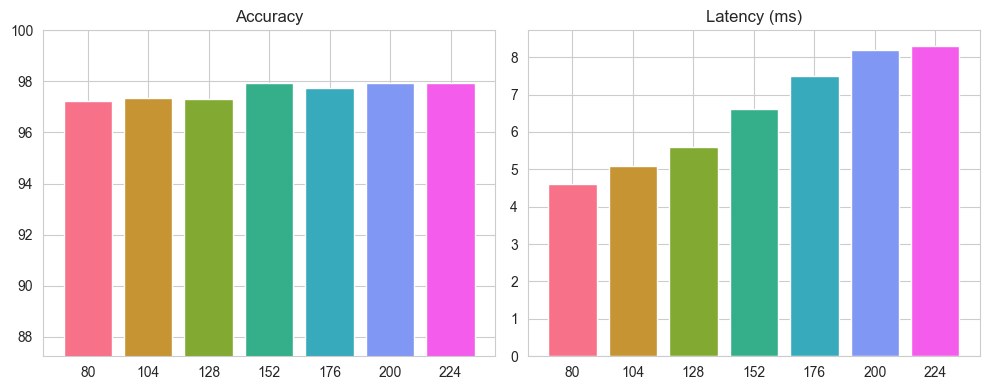

In [7]:
models = {
    "MobileNetV3 Small - Resolution 80":  "80",
    "MobileNetV3 Small - Resolution 104": "104",
    "MobileNetV3 Small - Resolution 128": "128", 
    "MobileNetV3 Small - Resolution 152": "152", 
    "MobileNetV3 Small - Resolution 176": "176", 
    "MobileNetV3 Small - Resolution 200": "200", 
    "MobileNetV3 Small - Resolution 224": "224"
}

stats = get_model_stats_from_json("../model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, show_params=False)

### Running Accuracy and Loss

- Running data can be collected by training the model and recording the loss-per-batch and accuracy-per-epoch.

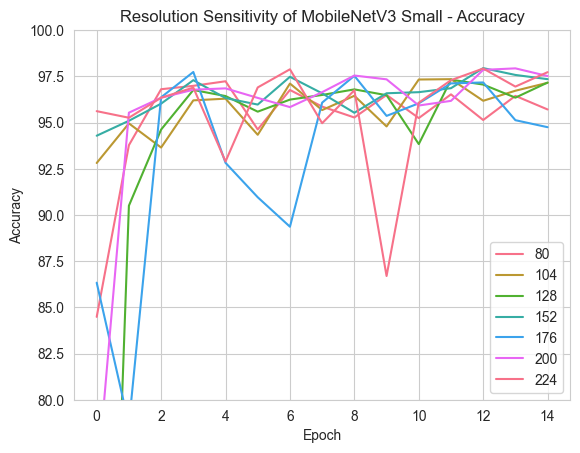

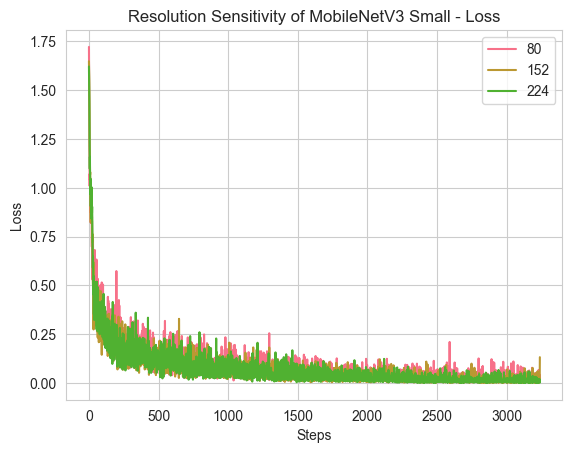

In [8]:
running_accuracy_raw = np.loadtxt("../Running-Data/running_acc_2.txt")
running_loss_raw     = np.loadtxt("../Running-Data/running_loss_2.txt")
running_accuracy     = dict()
running_loss         = dict()
for i, accs in enumerate(running_accuracy_raw):
    running_accuracy[str(resolutions[i])] = accs

running_loss[80]  = running_loss_raw[0]
running_loss[152] = running_loss_raw[3]
running_loss[224] = running_loss_raw[6]

compare_list_values(
    running_accuracy,
    y_axis  = "Accuracy",
    x_axis  = "Epoch",
    title   = "Resolution Sensitivity of MobileNetV3 Small - Accuracy",
    y_range = (80, 100),
)
compare_list_values(
    running_loss,
    y_axis = "Loss",
    x_axis = "Steps",
    title  = "Resolution Sensitivity of MobileNetV3 Small - Loss",
)

## VGG Pruning

### Per-layer Sparsity

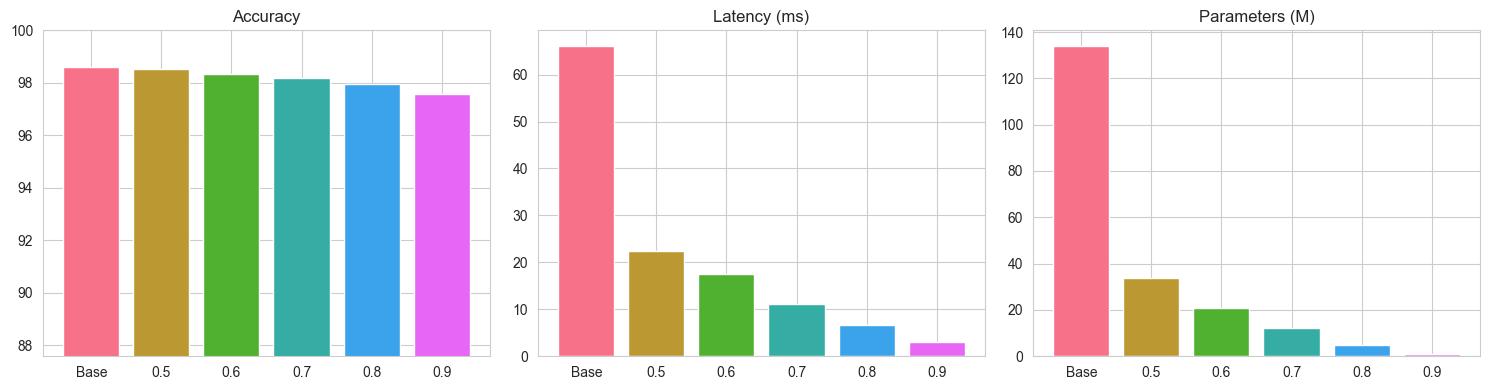

In [9]:
models = {
    "VGG16":                     "Base",
    "VGG16 - Layer Pruned 0.5":  "0.5",
    "VGG16 - Layer Pruned 0.6":  "0.6",
    "VGG16 - Layer Pruned 0.7":  "0.7",
    "VGG16 - Layer Pruned 0.8":  "0.8",
    "VGG16 - Layer Pruned 0.9":  "0.9",
}

stats = get_model_stats_from_json("../model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, fig_size=(15, 4))

### Global Sparsity

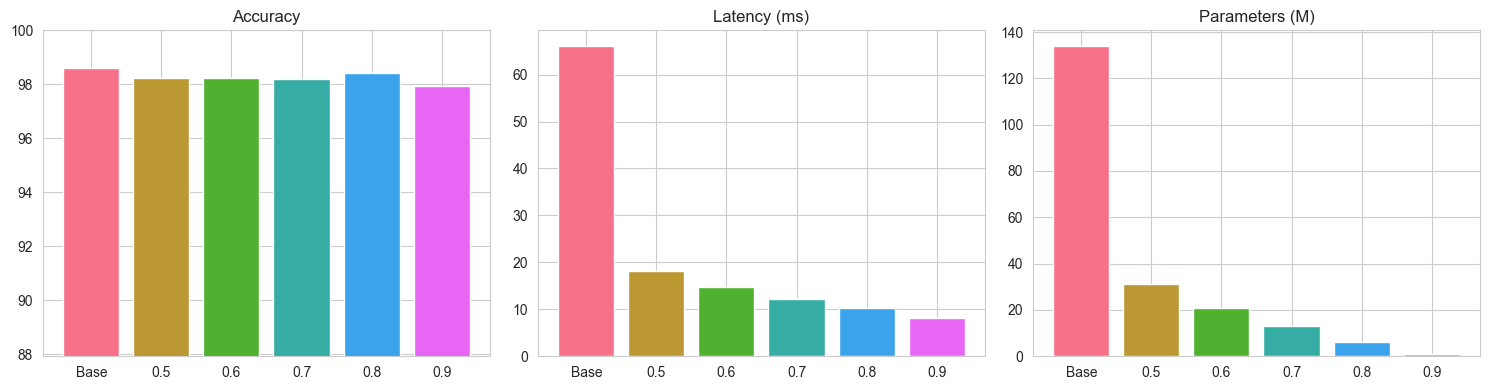

In [10]:
models = {
    "VGG16":                      "Base",
    "VGG16 - Global Pruned 0.5":  "0.5",
    "VGG16 - Global Pruned 0.6":  "0.6",
    "VGG16 - Global Pruned 0.7":  "0.7",
    "VGG16 - Global Pruned 0.8":  "0.8",
    "VGG16 - Global Pruned 0.9":  "0.9",
}

stats = get_model_stats_from_json("../model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

compare_models(stats, show_macs=False, fig_size=(15, 4))

### Per-layer vs Global

In [14]:
def plot_layer_vs_global(stats):
    names   = ["0.5", "0.6", "0.7", "0.8", "0.9"]
    accs    = [(stats[i].accuracy, stats[i+1].accuracy) for i in range(0, len(stats), 2)]
    latency = [(stats[i].latency, stats[i+1].latency) for i in range(0, len(stats), 2)]

    colors = sns.color_palette("husl", 2)

    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    current_bar = 0
    for group in accs:
        ax[0].bar(current_bar, group[0], color=colors[0])
        current_bar += 1

        ax[0].bar(current_bar, group[1], color=colors[1])
        current_bar += 2

    current_bar = 0
    for group in latency:
        ax[1].bar(current_bar, round(group[0] * 1000, 1), color=colors[0])
        current_bar += 1

        ax[1].bar(current_bar, round(group[1] * 1000, 1), color=colors[1])
        current_bar += 2

    ax[0].set_ylim([97, 100])
    ax[0].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[0].set_xticklabels(names)
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Sparsity")
    ax[0].legend(["Layer", "Global"])

    ax[1].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[1].set_xticklabels(names)
    ax[1].set_title("Latency (ms)")
    ax[1].set_xlabel("Sparsity")
    ax[1].legend(["Layer", "Global"])

    plt.show()

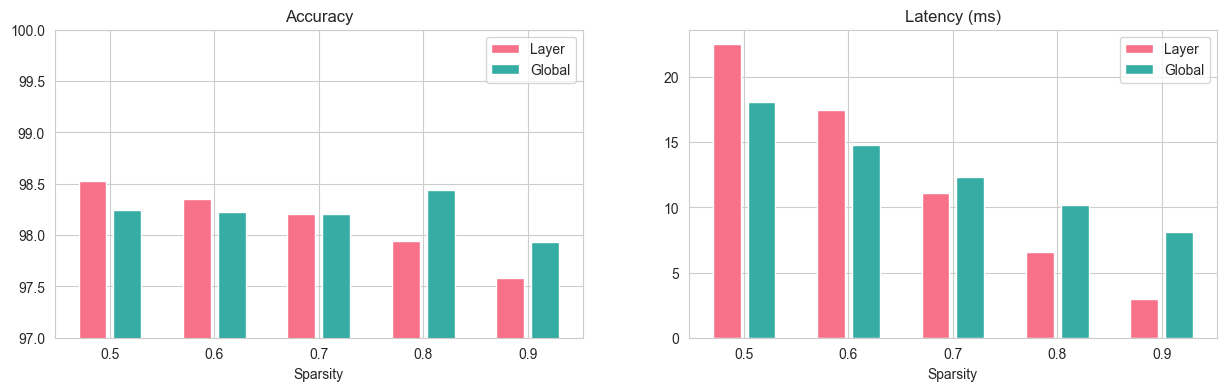

In [15]:
models = {
    "VGG16 - Layer Pruned 0.5":  "0.5",
    "VGG16 - Global Pruned 0.5": "0.5",
    "VGG16 - Layer Pruned 0.6":  "0.6",
    "VGG16 - Global Pruned 0.6": "0.6",
    "VGG16 - Layer Pruned 0.7":  "0.7",
    "VGG16 - Global Pruned 0.7": "0.7",
    "VGG16 - Layer Pruned 0.8":  "0.8",
    "VGG16 - Global Pruned 0.8": "0.8",
    "VGG16 - Layer Pruned 0.9":  "0.9",
    "VGG16 - Global Pruned 0.9": "0.9",
}

stats = get_model_stats_from_json("../model_stats.json", models)
for stat in stats:
    stat.name = models[stat.name]

plot_layer_vs_global(stats)

## Quantization

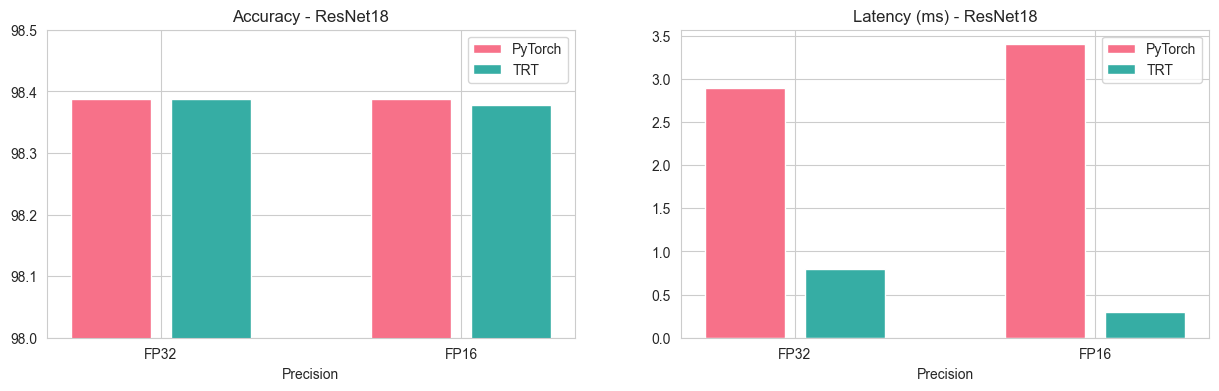

Base - TRT16: 0.009139654994896773
Latency reduction: 8.469286766104993


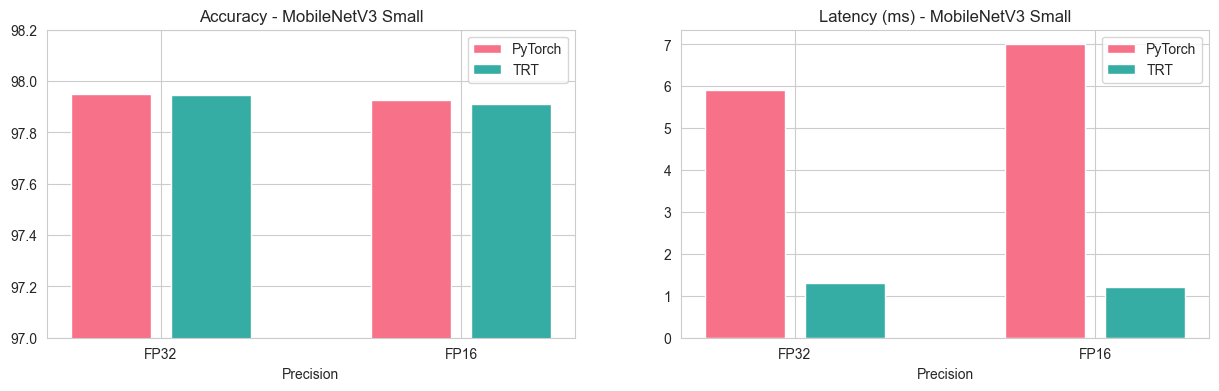

Base - TRT16: 0.036540941196236076
Latency reduction: 5.059836883463307


In [12]:
def plot_base_vs_trt(stats, accuracy_range, model):
    names   = ["FP32", "FP16"]
    accs    = [(stats[i].accuracy, stats[i+1].accuracy) for i in range(0, len(stats), 2)]
    latency = [(stats[i].latency, stats[i+1].latency) for i in range(0, len(stats), 2)]

    colors = sns.color_palette("husl", 2)

    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    current_bar = 0
    for group in accs:
        ax[0].bar(current_bar, group[0], color=colors[0])
        current_bar += 1

        ax[0].bar(current_bar, group[1], color=colors[1])
        current_bar += 2

    current_bar = 0
    for group in latency:
        ax[1].bar(current_bar, round(group[0] * 1000, 1), color=colors[0])
        current_bar += 1

        ax[1].bar(current_bar, round(group[1] * 1000, 1), color=colors[1])
        current_bar += 2

    ax[0].set_ylim(accuracy_range)
    ax[0].set_xticks([0.5, 3.5])
    ax[0].set_xticklabels(names)
    ax[0].set_title(f"Accuracy - {model}")
    ax[0].set_xlabel("Precision")
    ax[0].legend(["PyTorch", "TRT"])

    ax[1].set_xticks([0.5, 3.5])
    ax[1].set_xticklabels(names)
    ax[1].set_title(f"Latency (ms) - {model}")
    ax[1].set_xlabel("Precision")
    ax[1].legend(["PyTorch", "TRT"])

    plt.show()

resnet_models = [
    "ResNet18 - FP32", "ResNet18 - TRT FP32",
    "ResNet18 - FP16", "ResNet18 - TRT FP16"
]
stats = get_model_stats_from_json("../model_stats.json", resnet_models, sort=True)
plot_base_vs_trt(stats, (98, 98.5), "ResNet18")
print(f"Base - TRT16: {stats[0].accuracy - stats[3].accuracy}")
print(f"Latency reduction: {stats[0].latency / stats[3].latency}")

mobile_models = [
    "MobileNetV3 Small - FP32", "MobileNetV3 Small - TRT FP32",
    "MobileNetV3 Small - FP16", "MobileNetV3 Small - TRT FP16",
]
stats = get_model_stats_from_json("../model_stats.json", mobile_models, sort=True)
plot_base_vs_trt(stats, (97, 98.2), "MobileNetV3 Small")
print(f"Base - TRT16: {stats[0].accuracy - stats[3].accuracy}")
print(f"Latency reduction: {stats[0].latency / stats[3].latency}")

## VGG Quantization

### VGG Resolution Changes for ONNX Export

In [3]:
running_accuracy_224 = np.loadtxt("../Running-Data/vgg_acc_224.txt")
running_accuracy_152 = np.loadtxt("../Running-Data/vgg_acc_152.txt")

print("Resolution 224")
top, mean, std = compute_top_mean_std(running_accuracy_224) 
print(top, mean, std)

print("Resolution 152")
top, mean, std = compute_top_mean_std(running_accuracy_152) 
print(top, mean, std)


Resolution 224
Top:  98.63
Mean: 98.31
Std:  0.46
Resolution 152
Top:  98.78
Mean: 98.41
Std:  0.22


### Main Quantization Results

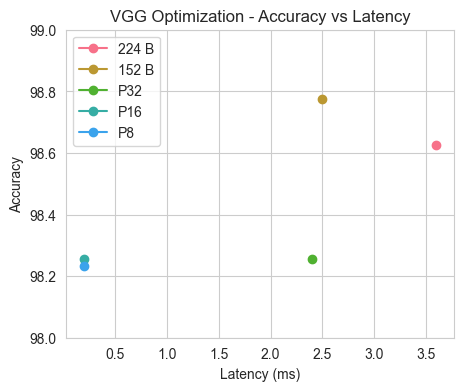

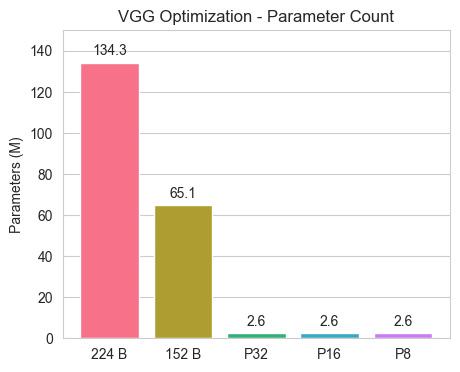

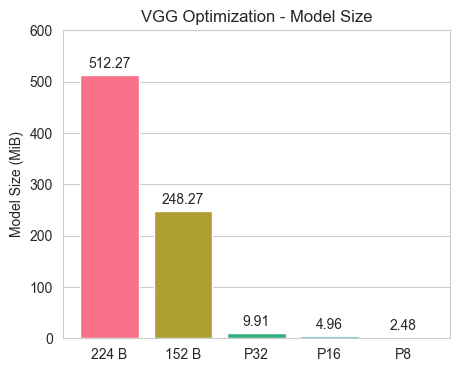

Size of 224 B: 512.2737007141113
Size of P16: 4.956932067871094
Size of P8: 2.478466033935547

Reductions 224 B => P16
	Accuracy: 0.37 (99.62%)
	Latency:  0.00 (14.93x)
	Params:   131690617.00 (51.67x)
	Size:     507.32 (103.34x)

Reductions 224 B => P8
	Accuracy: 0.39 (99.60%)
	Latency:  0.00 (15.96x)
	Params:   131690617.00 (51.67x)
	Size:     509.80 (206.69x)

Name:     224 B
Accuracy: 98.63%
Latency:  3.6 ms
Params:   134 M
MACs:     15520 M

Name:     152 B
Accuracy: 98.78%
Latency:  2.5 ms
Params:   65 M
MACs:     7076 M

Name:     P32
Accuracy: 98.26%
Latency:  2.4 ms
Params:   3 M
MACs:     284 M

Name:     P16
Accuracy: 98.26%
Latency:  0.2 ms
Params:   3 M
MACs:     284 M

Name:     P8
Accuracy: 98.23%
Latency:  0.2 ms
Params:   3 M
MACs:     284 M



In [3]:
models = {
    "VGG16 - Resolution 224 - FP32":                  "224 B",
    "VGG16 Custom 152 - FP32":                        "152 B",
    "VGG16 Custom 152 - Layer Pruned 0.8 - FP32":     "P32",
    "VGG16 Custom 152 - Layer Pruned 0.8 - TRT FP16": "P16",
    "VGG16 Custom 152 - Layer Pruned 0.8 - TRT INT8": "P8",
}

stats = get_model_stats_from_json("../model_stats.json", models, sort=True)
for stat in stats:
    stat.name = models[stat.name]

# Accuracy vs Latency
accuracy_vs_latency = {
    stat.name: [(round(stat.latency * 1000, 1), stat.accuracy)] for stat in stats
}
config = PlotConfig(
    title    = "VGG Optimization - Accuracy vs Latency",
    x_label  = "Latency (ms)",
    y_label  = "Accuracy",
    y_range  = (98, 99),
    fig_size = (5, 4)
)
compare_pairwise(accuracy_vs_latency, config)

# Parameters
parameters = {
    stat.name: round(stat.params / 1e6, 1) for stat in stats
}
config = PlotConfig(
    title    = "VGG Optimization - Parameter Count",
    y_label  = "Parameters (M)",
    y_range  = (0, 150),
    x_grid   = False,
    fig_size = (5, 4)
)
compare_single_values(parameters, config, horizontal=False)

# Size
sizes = {
    stat.name: stat.params * 32 / MiB for stat in stats
}
sizes["P16"] = sizes["P32"] / 2
sizes["P8"] = sizes["P32"] / 4

for name, size in sizes.items():
    sizes[name] = round(size, 2)

config = PlotConfig(
    title    = "VGG Optimization - Model Size",
    y_label  = "Model Size (MiB)",
    y_range  = (0, 600),
    x_grid   = False,
    fig_size = (5, 4)
)
compare_single_values(sizes, config, horizontal=False)

# Reductions
parameters = {stat.name: stat.params for stat in stats}
accuracy   = {stat.name: stat.accuracy for stat in stats}
latency   = {stat.name: stat.latency for stat in stats}

size_224B  = parameters["224 B"] * 32 / MiB
size_P16   = parameters["P32"] * 16 / MiB
size_P8    = parameters["P32"] * 8 / MiB
print(f"Size of 224 B: {size_224B}")
print(f"Size of P16: {size_P16}")
print(f"Size of P8: {size_P8}")
print()

precisions = ["P16", "P8"]
for pr in precisions:
    accuracy_difference = accuracy['224 B'] - accuracy[pr]
    accuracy_maintained = accuracy[pr] / accuracy['224 B'] * 100
    latency_difference  = latency['224 B'] - latency[pr]
    latency_reduction   = latency['224 B'] / latency[pr]
    param_difference    = parameters['224 B'] - parameters[pr]
    param_reduction     = parameters['224 B'] / parameters[pr]

    size = size_P16 if pr == "P16" else size_P8
    size_difference     = size_224B - size
    size_reduction      = size_224B / size

    print(f"Reductions 224 B => {pr}")
    print(f"\tAccuracy: {accuracy_difference:.2f} ({accuracy_maintained:.2f}%)")
    print(f"\tLatency:  {latency_difference:.2f} ({latency_reduction:.2f}x)")
    print(f"\tParams:   {param_difference:.2f} ({param_reduction:.2f}x)")
    print(f"\tSize:     {size_difference:.2f} ({size_reduction:.2f}x)")
    print()

# All stats
for stat in stats:
    display_model_stats(stat)
    print()

## Raw ECG Data Preprocessing Optimizations

### Dataset Shrinking

Balance 0.7 ===
Top: 98.89, Mean: 98.83, STD: 0.0107, Abs Diff: 0.0051, Rel Diff: 1.0001

Random 0.7 ===
Top: 98.82, Mean: 98.76, STD: 0.0152, Abs Diff: -0.0591, Rel Diff: 0.9994

Balance 0.6 ===
Top: 98.75, Mean: 98.71, STD: 0.0195, Abs Diff: -0.1127, Rel Diff: 0.9989

Random 0.6 ===
Top: 98.75, Mean: 98.72, STD: 0.0136, Abs Diff: -0.1071, Rel Diff: 0.9989

Balance 0.5 ===
Top: 98.76, Mean: 98.66, STD: 0.0253, Abs Diff: -0.1595, Rel Diff: 0.9984

Random 0.5 ===
Top: 98.69, Mean: 98.67, STD: 0.0153, Abs Diff: -0.1562, Rel Diff: 0.9984

Balance 0.4 ===
Top: 98.61, Mean: 98.5, STD: 0.032, Abs Diff: -0.3204, Rel Diff: 0.9968

Random 0.4 ===
Top: 98.66, Mean: 98.63, STD: 0.0153, Abs Diff: -0.1921, Rel Diff: 0.9981

Balance 0.3 ===
Top: 98.41, Mean: 98.32, STD: 0.047, Abs Diff: -0.504, Rel Diff: 0.9949

Random 0.3 ===
Top: 98.56, Mean: 98.52, STD: 0.0227, Abs Diff: -0.3066, Rel Diff: 0.9969



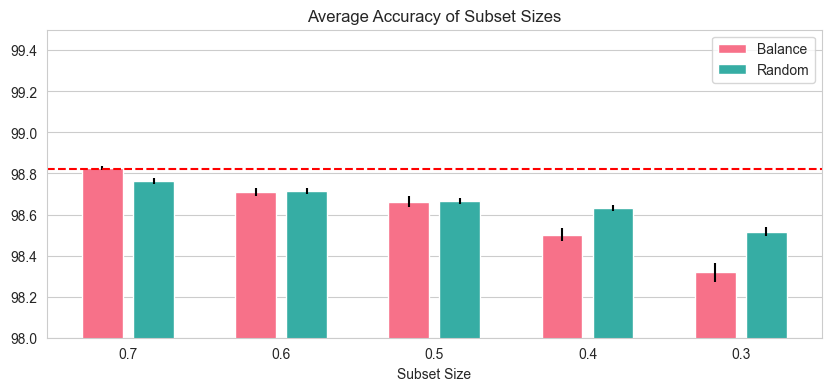

98.82281188964843
98.82281188964843
{'top': (-0.02978515625, 0.9996987991080318), 'mean': (-0.005129750569665248, 0.9999480941271818), 'std': (0.0034098180050705588, 1.3194676751293914)}
{'top': (0.45174407958984375, 1.004590592862613), 'mean': (0.5040382385253821, 1.0051265716587752), 'std': (-0.03287724028383968, 0.29989578903631176)}
Base ===
Top: 98.86, Mean: 98.82, STD: 0.0141, Abs Diff: 0.0, Rel Diff: 1.0


In [2]:
def add_base_bar(ax: plt.Axes, config: PlotConfig):
    base_stats = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
    top, mean, std = compute_top_mean_std(base_stats.running_accuracy, discard=20)

    ax.axhline(mean, color="red", linestyle="--")


def compare_training_stats(stat_1: TrainingStats, stat_2: TrainingStats, discard: int) -> dict[str, tuple[float, float]]:
    top_1, mean_1, std_1 = compute_top_mean_std(stat_1.running_accuracy, discard=discard)
    top_2, mean_2, std_2 = compute_top_mean_std(stat_2.running_accuracy, discard=discard)
    print(mean_1)

    comparison = dict()
    comparison["top"]  = (top_1 - top_2, top_1 / top_2)
    comparison["mean"] = (mean_1 - mean_2, mean_1 / mean_2)
    comparison["std"]  = (std_1 - std_2, std_1 / std_2)

    return comparison


def display_all_stats(stat: TrainingStats, name: str) -> None:
    base_stats = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
    top_base, mean_base, std_base = compute_top_mean_std(base_stats.running_accuracy, discard=20)

    top, mean, std = compute_top_mean_std(stat.running_accuracy, discard=20)

    mean_diff      = mean - mean_base
    mean_diff_norm = mean / mean_base

    print(f"{name} ===")
    print(f"Top: {round(top, 2)}, Mean: {round(mean, 2)}, STD: {round(std, 4)}, Abs Diff: {round(mean_diff, 4)}, Rel Diff: {round(mean_diff_norm, 4)}")


ratios = ["0.7", "0.6", "0.5", "0.4", "0.3"]
groups = GroupedValues()

for ratio in ratios:
    balance_train_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r{ratio}_balance/stats.txt")
    top, mean, std = compute_top_mean_std(balance_train_stats.running_accuracy, discard=20)
    groups.add_to_group(ratio, mean, std)
    display_all_stats(balance_train_stats, f"Balance {ratio}")
    print()

    random_train_stats  = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r{ratio}_random/stats.txt")
    top, mean, std = compute_top_mean_std(random_train_stats.running_accuracy, discard=20)
    groups.add_to_group(ratio, mean, std)
    display_all_stats(random_train_stats, f"Random {ratio}")
    print()

config = PlotConfig(
    title   = "Average Accuracy of Subset Sizes",
    x_label = "Subset Size",
    y_range = (98, 99.5),
    legend  = ["Balance", "Random"]
)
grouped_bar_plot(groups, config, callback=add_base_bar)

# Reduction stats
stats_base = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
stats_07   = TrainingStats(from_save="../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r0.7_balance/stats.txt")
stats_03   = TrainingStats(from_save="../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r0.3_balance/stats.txt")

base_vs_07 = compare_training_stats(stats_base, stats_07, 20)
base_vs_03 = compare_training_stats(stats_base, stats_03, 20)

print(base_vs_07)
print(base_vs_03)

display_all_stats(stats_base, "Base")

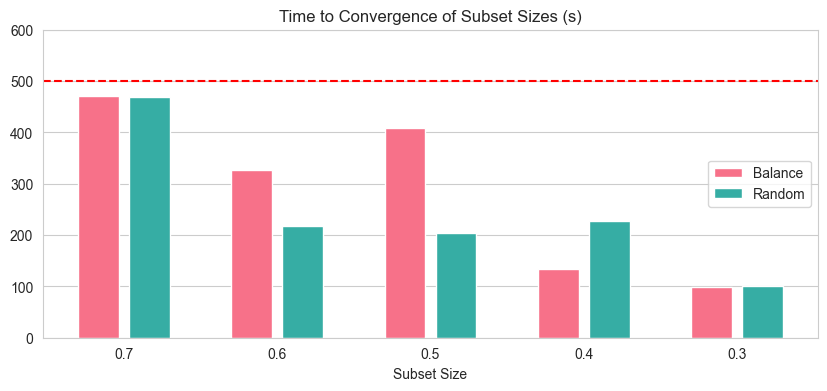

In [3]:
def add_base_bar(ax: plt.Axes, config: PlotConfig):
    base_stats      = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
    top, mean, std  = compute_top_mean_std(base_stats.running_accuracy, discard=20)
    time_per_epoch  = base_stats.training_time / len(base_stats.running_accuracy)
    epoch, cvg_time = time_to_convergence(base_stats.running_accuracy, time_per_epoch, std, 5)

    ax.axhline(cvg_time, color="red", linestyle="--")

ratios = ["0.7", "0.6", "0.5", "0.4", "0.3"]
convergence = GroupedValues()

for ratio in ratios:
    balance_train_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r{ratio}_balance/stats.txt")
    top, mean, std      = compute_top_mean_std(balance_train_stats.running_accuracy, discard=20)
    time_per_epoch      = balance_train_stats.training_time / len(balance_train_stats.running_accuracy)
    epoch, cvg_time     = time_to_convergence(balance_train_stats.running_accuracy, time_per_epoch, std, 5)
    convergence.add_to_group(ratio, cvg_time, 0)

    random_train_stats  = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Dataset-Shrinking/resnet18_ep50_i128_r{ratio}_random/stats.txt")
    top, mean, std      = compute_top_mean_std(random_train_stats.running_accuracy, discard=20)
    time_per_epoch      = random_train_stats.training_time / len(random_train_stats.running_accuracy)
    epoch, cvg_time     = time_to_convergence(random_train_stats.running_accuracy, time_per_epoch, std, 5)
    convergence.add_to_group(ratio, cvg_time, 0)

config = PlotConfig(
    title   = "Time to Convergence of Subset Sizes (s)",
    x_label = "Subset Size",
    y_range = (0, 600),
    legend  = ["Balance", "Random"]
)
grouped_bar_plot(convergence, config, callback=add_base_bar)

### Window Shrinking

#### Dataset Scaling

=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.86 | 98.82 | 0.0141 | ------ | ------
Random  | 99.02 | 99.00 | 0.0084 | 0.1764 | 1.0018
Balance | 99.21 | 99.18 | 0.0150 | 0.3571 | 1.0036


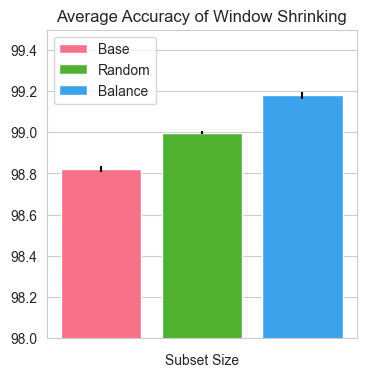

In [32]:
# Base vs Balance vs Random
groups = GroupedValues()

stats_base = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
top, mean, std = compute_top_mean_std(stats_base.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_random = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/random/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_random.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

stats_balance = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_balance.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

display_training_stat_table([stats_random, stats_balance], stats_base, ["Random  ", "Balance "], "128")


config = PlotConfig(
    title    = "Average Accuracy of Window Shrinking",
    x_label  = "Subset Size",
    y_range  = (98, 99.5),
    legend   = ["Base", "Random", "Balance"],
    fig_size = (4, 4)
)
grouped_bar_plot(groups, config)

=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 99.21 | 99.18 | 0.0150 | ------ | ------
Large   | 99.14 | 99.13 | 0.0089 | -0.0529 | 0.9995
Small   | 99.09 | 99.05 | 0.0142 | -0.1273 | 0.9987



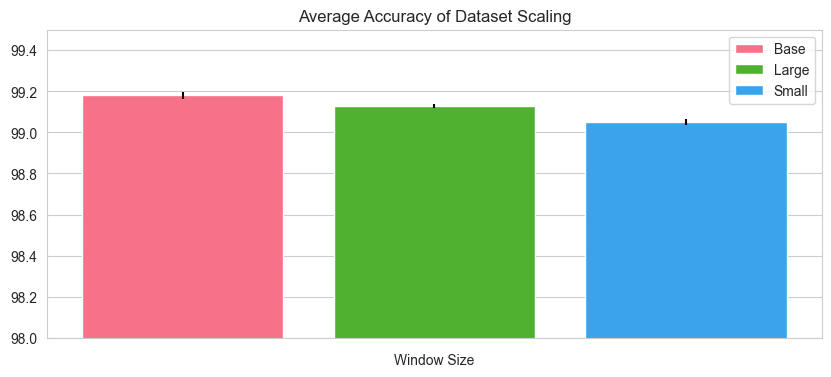

In [34]:
groups = GroupedValues()

stats_norm = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_norm.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

stats_large = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Large/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_large.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

stats_small = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Small/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_small.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

display_training_stat_table([stats_large, stats_small], stats_norm, ["Large   ", "Small   "], f"{128:3}", 10)
print()

config = PlotConfig(
    title   = "Average Accuracy of Dataset Scaling",
    x_label = "Window Size",
    y_range = (98, 99.5),
    legend  = ["Base", "Large", "Small"]
)
grouped_bar_plot(groups, config)

In [23]:
import h5py

large = get_dataset_size(256, 3, 80554, 32)

resolutions = [(256, 0.3), (224, 0.3), (192, 0.4), (160, 0.5), (128, 1.0)]
for res, ratio in resolutions:
    if res == 128:
        path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/image_unfiltered_i{res}_train.h5"
    else:
        path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/image_unfiltered_i{res}_train_r{ratio}_balance.h5"
    with h5py.File(path, "r") as hdf:
        num_samples = len(hdf["images"])
        size = get_dataset_size(res, 3, num_samples, 32)
        print(f"{res}: {size}")

256: 17.69970703125
224: 13.552459716796875
192: 13.276290893554688
160: 11.525344848632812
128: 14.75372314453125


#### Main Results

0.015024987010860441
=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.86 | 98.82 | 0.0141 | ------ | ------
Normal  | 99.21 | 99.18 | 0.0150 | 0.3571 | 1.0036

0.03488590669977262
===  96 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.65 | 98.62 | 0.0141 | ------ | ------
Normal  | 98.83 | 98.79 | 0.0349 | 0.1688 | 1.0017

0.10967795942067385
===  64 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.19 | 97.99 | 0.1429 | ------ | ------
Normal  | 98.28 | 98.15 | 0.1097 | 0.1672 | 1.0017



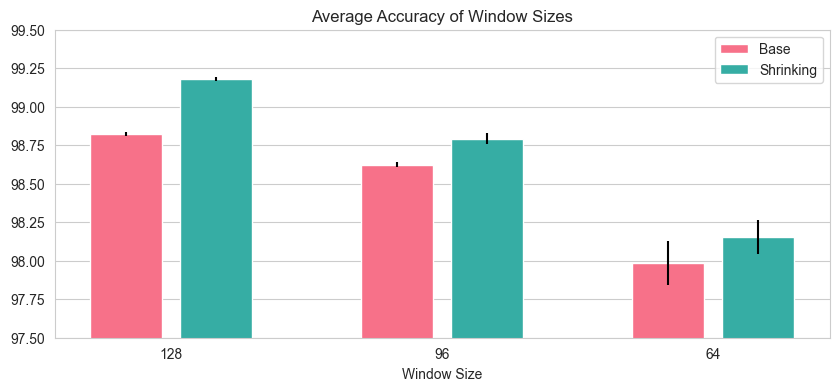

In [26]:
window_sizes = [128, 96, 64]
groups = GroupedValues()

for window_size in window_sizes:
    stats_base = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i{window_size}/stats.txt")
    top, mean, std = compute_top_mean_std(stats_base.running_accuracy, discard=20)
    groups.add_to_group(window_size, mean, std)

    stats_norm = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/resnet18_ep30_i{window_size}_r1.0/stats.txt")
    top, mean, std = compute_top_mean_std(stats_norm.running_accuracy, discard=10)
    print(std)
    groups.add_to_group(window_size, mean, std)

    display_training_stat_table([stats_norm], stats_base, ["Normal  "], f"{window_size:3}")
    print()

config = PlotConfig(
    title   = "Average Accuracy of Window Sizes",
    x_label = "Window Size",
    y_range = (97.5, 99.5),
    legend  = ["Base", "Shrinking"]
)
grouped_bar_plot(groups, config)

#### Different Image Transformation

=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.86 | 98.82 | 0.0141 | ------ | ------
Normal  | 99.21 | 99.18 | 0.0150 | 0.3571 | 1.0036
Crop    | 98.93 | 98.90 | 0.0131 | 0.0806 | 1.0008
Resize  | 99.17 | 99.15 | 0.0154 | 0.3271 | 1.0033
Resize2 | 98.96 | 98.94 | 0.0193 | 0.1143 | 1.0012


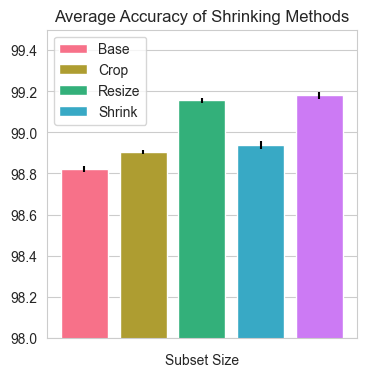

In [13]:
groups = GroupedValues()

stats_base = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
top, mean, std = compute_top_mean_std(stats_base.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_crop = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128_crop/stats.txt")
top, mean, std = compute_top_mean_std(stats_crop.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_resize = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128_resize/stats.txt")
top, mean, std = compute_top_mean_std(stats_resize.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_resize_ft = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep30_i128_resize_back/stats.txt")
top, mean, std = compute_top_mean_std(stats_resize_ft.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

stats_shrink = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_shrink.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

display_training_stat_table([stats_shrink, stats_crop, stats_resize, stats_resize_ft], stats_base, ["Normal  ", "Crop    ", "Resize  ", "Resize2 "], "128")

config = PlotConfig(
    title    = "Average Accuracy of Shrinking Methods",
    x_label  = "Subset Size",
    y_range  = (98, 99.5),
    legend   = ["Base", "Crop", "Resize", "Shrink"],
    fig_size = (4, 4)
)
grouped_bar_plot(groups, config)

=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.86 | 98.82 | 0.0141 | ------ | ------
Resize  | 99.17 | 99.15 | 0.0154 | 0.3271 | 1.0033
Window  | 99.21 | 99.18 | 0.0150 | 0.3571 | 1.0036
Resize P| 99.25 | 99.22 | 0.0103 | 0.3989 | 1.0040


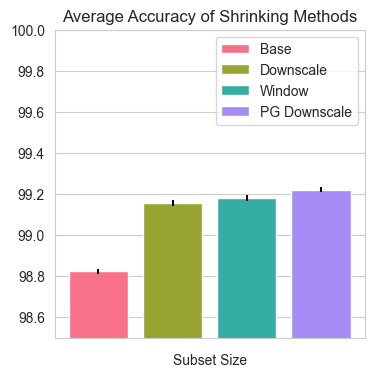

In [10]:
groups = GroupedValues()

stats_base = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
top, mean, std = compute_top_mean_std(stats_base.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_resize = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128_resize/stats.txt")
top, mean, std = compute_top_mean_std(stats_resize.running_accuracy, discard=20)
groups.add_to_group("", mean, std)

stats_shrink = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_shrink.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

stats_resize_pr = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Resize/resnet18_ep30_i128_r1.0/stats.txt")
top, mean, std = compute_top_mean_std(stats_resize_pr.running_accuracy, discard=10)
groups.add_to_group("", mean, std)

display_training_stat_table([stats_resize, stats_shrink, stats_resize_pr], stats_base, ["Resize  ","Window  ", "Resize P"], "128")

config = PlotConfig(
    title    = "Average Accuracy of Shrinking Methods",
    x_label  = "Subset Size",
    y_range  = (98.5, 100),
    legend   = ["Base", "Downscale", "Window", "PG Downscale"],
    fig_size = (4, 4)
)
grouped_bar_plot(groups, config)

#### Shrinking Steps

=== 128 | Top   | Mean  | STD    | Abs    | Rel
Base    | 98.86 | 98.82 | 0.0141 | ------ | ------
128     | 98.96 | 98.93 | 0.0135 | 0.1114 | 1.0011
64      | 99.04 | 98.98 | 0.0177 | 0.1578 | 1.0016
32      | 99.21 | 99.18 | 0.0150 | 0.3571 | 1.0036
16      | 99.26 | 99.22 | 0.0132 | 0.3956 | 1.0040
8       | 99.30 | 99.28 | 0.0102 | 0.4551 | 1.0046


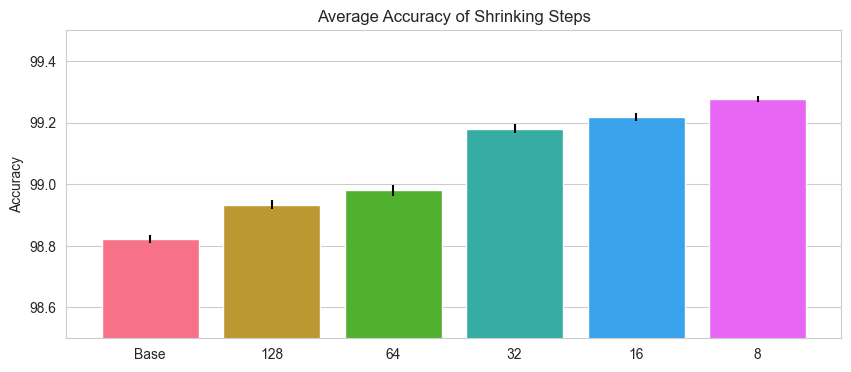

In [4]:
bars = dict()

stats_base = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
top, mean, std = compute_top_mean_std(stats_base.running_accuracy, discard=20)
bars["Base"] = (mean, std)

stats = []
steps = [128, 64, 32, 16, 8]
for step in steps:
    stat = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-{step}/resnet18_ep30_i128_r1.0/stats.txt")
    top, mean, std = compute_top_mean_std(stat.running_accuracy, discard=10)
    bars[str(step)] = (mean, std)

    stats.append(stat)

display_training_stat_table(stats, stats_base, ["128     ", "64      ", "32      ", "16      ", "8       "], "128")

config = PlotConfig(
    title    = "Average Accuracy of Shrinking Steps",
    x_label  = None,
    y_label  = "Accuracy",
    y_range  = (98.5, 99.5),
    x_grid   = False,
    fig_size = (10, 4)
)
bar_plot_error(bars, config, horizontal=False)

### MobileNet V3 Small 200 Epochs

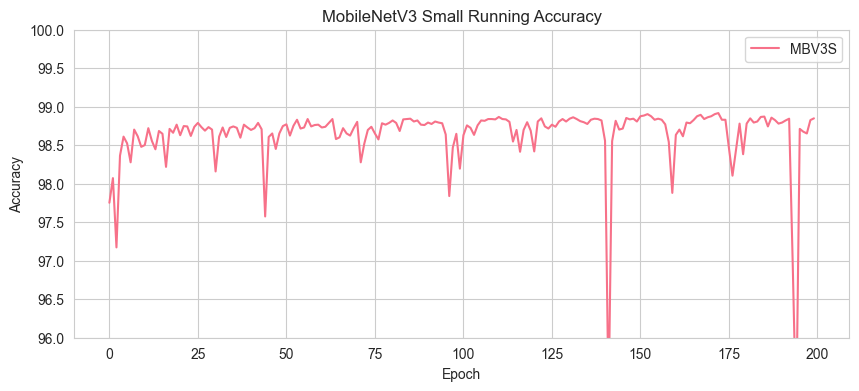

In [2]:
stats = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/mobilenet_v3_small_ep200_i128/stats.txt")

values = {"MBV3S" : stats.running_accuracy}

config = PlotConfig(
    title="MobileNetV3 Small Running Accuracy",
    x_label="Epoch",
    y_label="Accuracy",
    y_range=(96, 100),
)

compare_list_values(values, config)

### More Downsampling

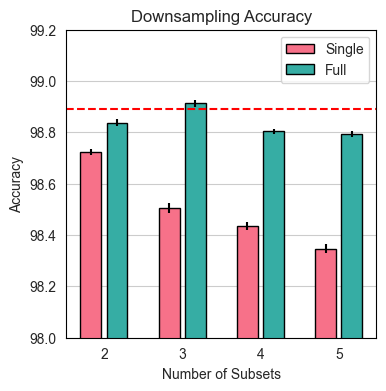

In [6]:
def add_base_bar(ax: plt.Axes, config: PlotConfig):
    base_stats = TrainingStats(from_save="../Pretrained/ECG-Raw/Base/Full-Split/Base/1/resnet18_ep100_i128/stats.txt")
    top, mean, std = compute_top_mean_std(base_stats.running_accuracy, discard=20)

    ax.axhline(top, color="red", linestyle="--")

    set_black_border(ax)


num_subsets = [2, 3, 4, 5]
groups = GroupedValues()

for s in num_subsets:
    single_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Base/{s}/resnet18_ep100_i128/stats.txt")
    top, mean, std = compute_top_mean_std(single_set_stats.running_accuracy, discard=20)
    groups.add_to_group(s, top, std)

    full_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Single/Sets-{s}/Set-{s-1}/resnet18_ep20_i128/stats.txt")
    top, mean, std = compute_top_mean_std(full_set_stats.running_accuracy, discard=10)
    groups.add_to_group(s, top, std)

config = PlotConfig(
    title    = "Downsampling Accuracy",
    x_label  = "Number of Subsets",
    y_label  = "Accuracy",
    y_range  = (98, 99.2),
    legend   = ["Single", "Full"],
    fig_size = (4, 4),
)
plot_bar_grouped(groups, config, callback=add_base_bar)

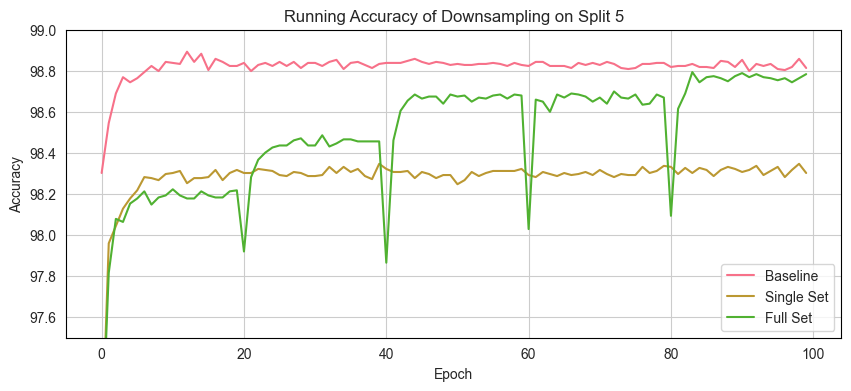

In [12]:
def add_black_border(ax: plt.Axes, config: PlotConfig):
    set_black_border(ax)

set_to_plot = 5
values      = dict()

baseline_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Base/1/resnet18_ep100_i128/stats.txt")
values["Baseline"] = baseline_stats.running_accuracy

single_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Base/{s}/resnet18_ep100_i128/stats.txt")
values[f"Single Set"]  = single_set_stats.running_accuracy

full_set_running_acc = []
for i in range(s):
    full_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Single/Sets-{s}/Set-{i}/resnet18_ep20_i128/stats.txt")
    full_set_running_acc += full_set_stats.running_accuracy

values[f"Full Set"] = full_set_running_acc

config = PlotConfig(
    title   = "Running Accuracy of Downsampling on Split 5",
    y_label = "Accuracy",
    y_range = (97.5, 99),
    x_label = "Epoch",
)

plot_xy_single(values, config, callback=add_black_border)

In [24]:
num_subsets = [2, 3, 4, 5]

table = PrettyTable()

table.field_names = ["", "Num Subsets", "Top Acc", "Abs Diff", "Rel Diff"]
for field in table.field_names:
    table.align[field] = "l"

baseline_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Base/1/resnet18_ep100_i128/stats.txt")
table.add_row(["Baseline", 1, round(baseline_stats.best_accuracy, 2), "-", "-"])

for s in num_subsets:
    table.add_row(["-"] * len(table.field_names))

    single_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Base/{s}/resnet18_ep100_i128/stats.txt")
    abs_diff = single_set_stats.best_accuracy - baseline_stats.best_accuracy
    rel_diff = single_set_stats.best_accuracy / baseline_stats.best_accuracy
    table.add_row(["Single Set", s, round(single_set_stats.best_accuracy, 2), round(abs_diff, 4), round(rel_diff, 4)])

    full_set_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Single/Sets-{s}/Set-{s-1}/resnet18_ep20_i128/stats.txt")
    abs_diff = full_set_stats.best_accuracy - baseline_stats.best_accuracy
    rel_diff = full_set_stats.best_accuracy / baseline_stats.best_accuracy
    table.add_row(["Full Set", s, round(full_set_stats.best_accuracy, 2), round(abs_diff, 4), round(rel_diff, 4)])

    avg_set_stats = get_model_stats_from_json(f"../Pretrained/ECG-Raw/Base/Full-Split/Multi/Sets-{s}/combined_stats.json", f"ResNet18 - Combined {s}")[0]
    abs_diff = avg_set_stats.accuracy - baseline_stats.best_accuracy
    rel_diff = avg_set_stats.accuracy / baseline_stats.best_accuracy
    table.add_row(["Average Set", s, round(avg_set_stats.accuracy, 2), round(abs_diff, 4), round(rel_diff, 4)])

print(table)
print(table.get_latex_string())

+-------------+-------------+---------+----------+----------+
|             | Num Subsets | Top Acc | Abs Diff | Rel Diff |
+-------------+-------------+---------+----------+----------+
| Baseline    | 1           | 98.89   | -        | -        |
| -           | -           | -       | -        | -        |
| Single Set  | 2           | 98.72   | -0.1688  | 0.9983   |
| Full Set    | 2           | 98.84   | -0.0546  | 0.9994   |
| Average Set | 2           | 97.14   | -1.7524  | 0.9823   |
| -           | -           | -       | -        | -        |
| Single Set  | 3           | 98.51   | -0.3872  | 0.9961   |
| Full Set    | 3           | 98.91   | 0.0199   | 1.0002   |
| Average Set | 3           | 95.43   | -3.4651  | 0.965    |
| -           | -           | -       | -        | -        |
| Single Set  | 4           | 98.44   | -0.4567  | 0.9954   |
| Full Set    | 4           | 98.8    | -0.0894  | 0.9991   |
| Average Set | 4           | 94.6    | -4.2941  | 0.9566   |
| -     

In [23]:
num_subsets = [2, 3, 4, 5]

table = PrettyTable()

table.field_names = ["", "Set", "Top", "Mean", "STD"]
for field in table.field_names:
    table.align[field] = "l"

for s in num_subsets:
    table.add_row(["-"] * len(table.field_names))
    for i in range(s):        
        avg_set_stats  = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/Full-Split/Multi/Sets-{s}/Set-{i}/resnet18_ep20_i128/stats.txt")
        top, mean, std = compute_top_mean_std(avg_set_stats.running_accuracy, discard=10)
        table.add_row([f"Subsets {s}", i, round(top, 2), round(mean, 2), round(std, 4)])

print(table)
print(table.get_latex_string())

+-----------+-----+-------+-------+--------+
|           | Set | Top   | Mean  | STD    |
+-----------+-----+-------+-------+--------+
| -         | -   | -     | -     | -      |
| Subsets 2 | 0   | 98.69 | 98.66 | 0.0236 |
| Subsets 2 | 1   | 98.67 | 98.63 | 0.007  |
| -         | -   | -     | -     | -      |
| Subsets 3 | 0   | 98.48 | 98.44 | 0.0184 |
| Subsets 3 | 1   | 98.53 | 98.5  | 0.0126 |
| Subsets 3 | 2   | 98.58 | 98.56 | 0.0117 |
| -         | -   | -     | -     | -      |
| Subsets 4 | 0   | 98.36 | 98.35 | 0.0067 |
| Subsets 4 | 1   | 98.38 | 98.35 | 0.0156 |
| Subsets 4 | 2   | 98.35 | 98.32 | 0.0193 |
| Subsets 4 | 3   | 98.51 | 98.47 | 0.0217 |
| -         | -   | -     | -     | -      |
| Subsets 5 | 0   | 98.17 | 98.14 | 0.0206 |
| Subsets 5 | 1   | 98.21 | 98.18 | 0.0159 |
| Subsets 5 | 2   | 98.38 | 98.32 | 0.0243 |
| Subsets 5 | 3   | 98.32 | 98.3  | 0.0109 |
| Subsets 5 | 4   | 98.33 | 98.32 | 0.0146 |
+-----------+-----+-------+-------+--------+
\begin{tab

### More Window Shrinking

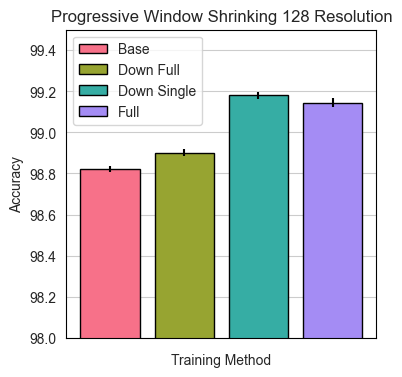

+-------------+-------+-------+--------+--------+--------+--------+
|             | Top   | Mean  | STD    | ABS    | REL    | Train  |
+-------------+-------+-------+--------+--------+--------+--------+
| Base        | 98.86 | 98.82 | 0.0141 | -      | -      | 1140   |
| Down Full   | 98.94 | 98.9  | 0.0178 | 0.0779 | 1.0008 | 2982.1 |
| Down Single | 99.21 | 99.18 | 0.015  | 0.3571 | 1.0036 | 1494.1 |
| Full        | 99.2  | 99.15 | 0.0198 | 0.3226 | 1.0033 | 3330.0 |
+-------------+-------+-------+--------+--------+--------+--------+
\begin{tabular}{lllllll}
 & Top & Mean & STD & ABS & REL & Train \\
Base & 98.86 & 98.82 & 0.0141 & - & - & 1140 \\
Down Full & 98.94 & 98.9 & 0.0178 & 0.0779 & 1.0008 & 2982.1 \\
Down Single & 99.21 & 99.18 & 0.015 & 0.3571 & 1.0036 & 1494.1 \\
Full & 99.2 & 99.15 & 0.0198 & 0.3226 & 1.0033 & 3330.0 \\
\end{tabular}


In [22]:
def add_black_border(ax: plt.Axes, config: PlotConfig):
    set_black_border(ax)

table = PrettyTable()
table.field_names = ["", "Top", "Mean", "STD", "ABS", "REL", "Train"]
for field in table.field_names:
    table.align[field] = "l"

groups = GroupedValues()

baseline_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Base/resnet18_ep50_i128/stats.txt")
base_top, base_mean, base_std = compute_top_mean_std(baseline_stats.running_accuracy, discard=20)
groups.add_to_group("", base_mean, base_std)
table.add_row(["Base", round(base_top, 2), round(base_mean, 2), round(base_std, 4), "-", "-", round(sum(baseline_stats.running_train_time, 1))])

stats = [
    ("Down Full",   TrainingStats(from_save="../Pretrained/ECG-Raw/Window-Shrinking/Full-Split/resnet18_ep30_i128_s0/stats.txt")),
    ("Down Single", TrainingStats(from_save="../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/resnet18_ep30_i128_r1.0/stats.txt")),
    ("Full",        TrainingStats(from_save="../Pretrained/ECG-Raw/Window-Shrinking/Full/resnet18_ep30_i128/stats.txt"))
]

for name, stat in stats:
    top, mean, std = compute_top_mean_std(stat.running_accuracy, discard=10)
    groups.add_to_group("", mean, std)

    total_train_time = 0
    resolution_sizes  = [256, 224, 192, 160]

    # Accumulate training times from the high resolution stages 
    match name:
        case "Down Single":
            ratios = [0.3, 0.3, 0.4, 0.5]
            for res, ratio in zip(resolution_sizes, ratios):
                int_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V2/resnet18_ep10_i{res}_r{ratio}/stats.txt")
                total_train_time += sum(int_stats.running_train_time)

        case "Down Full": 
            num_subsets = [4, 3, 2, 2]
            for res, s in zip(resolution_sizes, num_subsets):
                for i in range(s):
                    int_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/Full-Split/resnet18_ep10_i{res}_s{i}/stats.txt")
                    total_train_time += sum(int_stats.running_train_time)

        case "Full":
            for res in resolution_sizes:
                int_stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/Full/resnet18_ep10_i{res}/stats.txt")
                total_train_time += sum(int_stats.running_train_time)
    
    # Training time from the final stage
    total_train_time += sum(stat.running_train_time)

    table.add_row([
        name,
        round(top, 2), round(mean, 2), round(std, 4),
        round(mean - base_mean, 4), round(mean / base_mean, 4),
        round(total_train_time, 1),
    ])

config = PlotConfig(
    title    = "Progressive Window Shrinking 128 Resolution",
    x_label  = "Training Method",
    y_range  = (98, 99.5),
    y_label  = "Accuracy",
    legend   = ["Base", stats[0][0], stats[1][0], stats[2][0]],
    fig_size = (4, 4),
)
plot_bar_grouped(groups, config, callback=add_black_border)
print(table)
print(table.get_latex_string())

In [ ]:
# Collect evaluation stats
dataloader = build_dataloader(
    train_path   = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train.h5",
    test_path    = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_test.h5",
    batch_size   = 128,
    transform    = None,
    preload_test = True,
)

model_paths = [
    ("../Pretrained/ECG-Raw/Base", "resnet18_ep50_i128"),
    ("../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32", "resnet18_ep30_i128_r1.0"),
    ("../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-8", "resnet18_ep30_i128_r1.0"),
    ("../Pretrained/ECG-Raw/Window-Shrinking/Full", "resnet18_ep30_i128"),
]
for model_dir, model_name in model_paths:
    model = load_model_from_pretrained("resnet18", f"{model_dir}/{model_name}/{model_name}.pth", ArrhythmiaLabels.size).to(device)
    stats = evaluate_per_class(model, dataloader["test"], ArrhythmiaLabels.size)
    stats.serialize(f"{model_dir}/{model_name}/eval_stats.txt")
    del model

In [17]:
table = PrettyTable()
table.field_names = ["", "Class", "Acc", "P", "R", "F1"]
for field in table.field_names:
    table.align[field] = "l"

model_paths = [
    ("Baseline", "../Pretrained/ECG-Raw/Base/resnet18_ep50_i128"),
    ("32", "../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V1/resnet18_ep30_i128_r1.0"),
    ("8", "../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-8/resnet18_ep30_i128_r1.0"),
    ("32 Full", "../Pretrained/ECG-Raw/Window-Shrinking/Full/resnet18_ep30_i128"),
]
for c in range(ArrhythmiaLabels.size):
    for name, model_path in model_paths:
        stats = EvaluationStats(from_save=f"{model_path}/eval_stats.txt")
        row = [
            c,
            stats.per_class_accuracy[f"class_{c}"],
            stats.precision[f"class_{c}"],
            stats.recall[f"class_{c}"],
            stats.f1_score[f"class_{c}"],
        ]
        row = list(map(lambda x: round(x, 4), row))
        table.add_row([name] + row)

print(table)
print(table.get_latex_string())

+----------+-------+---------+--------+--------+--------+
|          | Class | Acc     | P      | R      | F1     |
+----------+-------+---------+--------+--------+--------+
| Baseline | 0     | 99.6889 | 0.9923 | 0.9969 | 0.9946 |
| 32       | 0     | 99.7834 | 0.9946 | 0.9978 | 0.9962 |
| 8        | 0     | 99.8111 | 0.9951 | 0.9981 | 0.9966 |
| 32 Full  | 0     | 99.8    | 0.9942 | 0.998  | 0.9961 |
| Baseline | 1     | 82.9044 | 0.9337 | 0.829  | 0.8783 |
| 32       | 1     | 88.0515 | 0.9523 | 0.8805 | 0.915  |
| 8        | 1     | 90.4412 | 0.9591 | 0.9044 | 0.9309 |
| 32 Full  | 1     | 87.6838 | 0.9578 | 0.8768 | 0.9155 |
| Baseline | 2     | 96.9166 | 0.9733 | 0.9692 | 0.9712 |
| 32       | 2     | 98.1079 | 0.9845 | 0.9811 | 0.9828 |
| 8        | 2     | 97.9678 | 0.9859 | 0.9797 | 0.9828 |
| 32 Full  | 2     | 98.3181 | 0.9804 | 0.9832 | 0.9818 |
| Baseline | 3     | 79.6407 | 0.8693 | 0.7964 | 0.8313 |
| 32       | 3     | 84.4311 | 0.9038 | 0.8443 | 0.8731 |
| 8        | 3

In [20]:
import h5py
from Dataset.data_generation import get_class_distribution

table = PrettyTable()
table.field_names = [""] + ArrhythmiaLabels.classes
for field in table.field_names:
    table.align[field] = "l"

with h5py.File("../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_test.h5", "r") as file:
    labels = file["labels"][:]

    dist = get_class_distribution(labels, False)
    table.add_row(["Raw", dist["normal"], dist["sveb"], dist["veb"], dist["fusion"], dist["unknown"]])

    dist = get_class_distribution(labels, True)
    row = dist["normal"], dist["sveb"], dist["veb"], dist["fusion"], dist["unknown"]
    table.add_row(["Norm"] + list(map(lambda x: round(x * 100, 4), row)))
    
print(table)
print(table.get_latex_string())

+------+---------+--------+-------+--------+---------+
|      | normal  | sveb   | veb   | fusion | unknown |
+------+---------+--------+-------+--------+---------+
| Raw  | 18003   | 544    | 1427  | 167    | 3       |
| Norm | 89.3715 | 2.7006 | 7.084 | 0.829  | 0.0149  |
+------+---------+--------+-------+--------+---------+
\begin{tabular}{llllll}
 & normal & sveb & veb & fusion & unknown \\
Raw & 18003 & 544 & 1427 & 167 & 3 \\
Norm & 89.3715 & 2.7006 & 7.084 & 0.829 & 0.0149 \\
\end{tabular}


### Stability Analysis

In [7]:
table = PrettyTable()
table.field_names = [""] + ["Top", "Mean", "STD"]
for field in table.field_names:
    table.align[field] = "l"

versions = [1, 2, 3, 4, 5]
for version in versions:
    stats = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V{version}/resnet18_ep30_i128_r1.0/stats.txt")
    top, mean, std = compute_top_mean_std(stats.running_accuracy, discard=10)
    table.add_row([
        f"Version {version}", f"{round(top, 2):.2f}", f"{round(mean, 2):.2f}", f"{round(std, 4):.4f}"
    ])

print(table)

[2024-07-29 16:08:05,224] [CLASS] [WARNING] ../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V1/resnet18_ep30_i128_r1.0/stats.txt is not in up to date. Current: 1, Newest: 2
[2024-07-29 16:08:05,225] [CLASS] [WARNING] ../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V2/resnet18_ep30_i128_r1.0/stats.txt is not in up to date. Current: 1, Newest: 2
[2024-07-29 16:08:05,227] [CLASS] [WARNING] ../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V3/resnet18_ep30_i128_r1.0/stats.txt is not in up to date. Current: 1, Newest: 2
[2024-07-29 16:08:05,228] [CLASS] [WARNING] ../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V4/resnet18_ep30_i128_r1.0/stats.txt is not in up to date. Current: 1, Newest: 2
[2024-07-29 16:08:05,229] [CLASS] [WARNING] ../Pretrained/ECG-Raw/Window-Shrinking/balance/Step-32/V5/resnet18_ep30_i128_r1.0/stats.txt is not in up to date. Current: 1, Newest: 2


+-----------+-------+-------+--------+
|           | Top   | Mean  | STD    |
+-----------+-------+-------+--------+
| Version 1 | 99.21 | 99.18 | 0.0150 |
| Version 2 | 99.16 | 99.13 | 0.0097 |
| Version 3 | 99.13 | 99.10 | 0.0138 |
| Version 4 | 99.15 | 99.13 | 0.0166 |
| Version 5 | 99.13 | 99.11 | 0.0081 |
+-----------+-------+-------+--------+


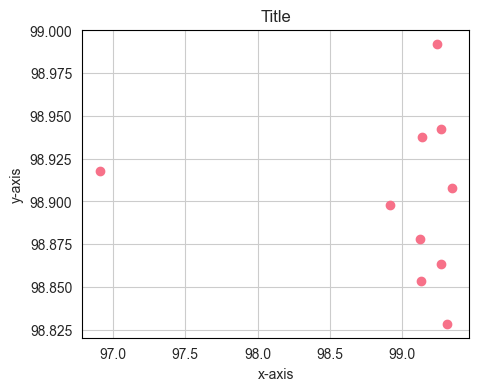

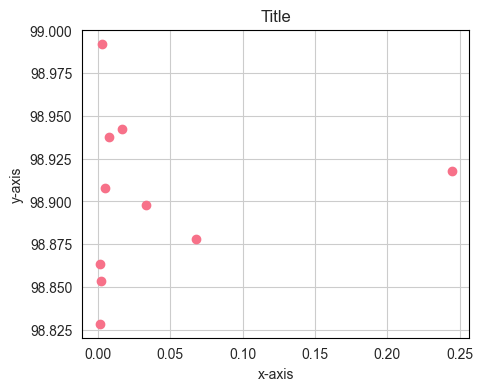

+---------+---------------+---------------+----------+-------+-------+--------+
|         | Prev Loss Sum | Prev Loss Avg | Prev Acc | Top   | Mean  | STD    |
+---------+---------------+---------------+----------+-------+-------+--------+
| Epoch 0 | 46.209222     | 0.244493      | 96.91    | 98.92 | 98.88 | 0.0199 |
| Epoch 1 | 12.815110     | 0.067805      | 99.13    | 98.88 | 98.86 | 0.0106 |
| Epoch 2 | 6.288787      | 0.033274      | 98.92    | 98.90 | 98.88 | 0.0099 |
| Epoch 3 | 3.161162      | 0.016726      | 99.27    | 98.94 | 98.92 | 0.0155 |
| Epoch 4 | 1.435992      | 0.007598      | 99.14    | 98.94 | 98.91 | 0.0153 |
| Epoch 5 | 0.873982      | 0.004624      | 99.34    | 98.91 | 98.89 | 0.0118 |
| Epoch 6 | 0.496593      | 0.002627      | 99.24    | 98.99 | 98.97 | 0.0230 |
| Epoch 7 | 0.348736      | 0.001845      | 99.13    | 98.85 | 98.84 | 0.0143 |
| Epoch 8 | 0.278468      | 0.001473      | 99.27    | 98.86 | 98.84 | 0.0113 |
| Epoch 9 | 0.208257      | 0.001102    

In [14]:
table = PrettyTable()
table.field_names = [""] + ["Prev Loss Sum", "Prev Loss Avg", "Prev Acc", "Top", "Mean", "STD"]
for field in table.field_names:
    table.align[field] = "l"

points_acc  = []
points_loss = []

for i in range(10):
    stats_256 = TrainingStats(from_save="../Pretrained/ECG-Raw/Window-Shrinking/Stability-Analysis/resnet18_ep10_i256/stats.txt")
    stats_128 = TrainingStats(from_save=f"../Pretrained/ECG-Raw/Window-Shrinking/Stability-Analysis/resnet18_ep20_i128_{i+1}/stats.txt")

    sum_loss_256 = sum(stats_256.running_loss[i])
    avg_loss_256 = np.mean(stats_256.running_loss[i])

    top, mean, std = compute_top_mean_std(stats_128.running_accuracy, discard=10)
    table.add_row([
        f"Epoch {i}", 
        f"{round(sum_loss_256, 6):.6f}", f"{round(avg_loss_256, 6):.6f}",
        f"{round(stats_256.running_accuracy[i], 2)}", f"{round(top, 2):.2f}", f"{round(mean, 2):.2f}", f"{round(std, 4):.4f}"
    ])

    points_acc.append((stats_256.running_accuracy[i], top))
    points_loss.append((avg_loss_256, top))

config = PlotConfig(
    fig_size=(5, 4)
)
plot_scatter(points_acc, config, callback=set_black_border)
plot_scatter(points_loss, config, callback=set_black_border)

print(table)

## Poster

In [3]:
from Quantization.benchmark_trt import benchmark_model_trt

json_path = "../model_stats.json"

dataloader = build_dataloader(
    train_path   = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_train.h5",
    test_path    = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_test.h5",
    batch_size   = 128,
    transform    = None,
    preload_test = True,
)

# Base model
base_model = load_model_from_pretrained("resnet50", "../Pretrained/ECG-Raw/Base/resnet50_ep50_i128/resnet50_ep50_i128.pth", 5)
base_stats = benchmark_model(base_model, dataloader["test"], "ResNet50 - Resolution 128", True)

dummy_input    = torch.rand((1, 3, 128, 128))
base_latencies = []
for _ in range(0, 10):
    base_latencies.append(measure_latency(base_model, dummy_input, test_device=device))
base_stats.latency = sum(base_latencies) / len(base_latencies)
print(base_latencies)

add_model_stat_to_json(json_path, base_stats)

del base_model
del dataloader

# Optimized model
dataloader = build_dataloader(
    train_path   = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_train.h5",
    test_path    = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_test.h5",
    batch_size   = 1,
    transform    = None,
    preload_test = True,
)

optimized_engine = "../Pretrained/ECG-Raw/Window-Shrinking/balance/ResNet50/resnet50_ep30_i128_r1.0/Quantization/Prune-0.7/resnet50_ep30_i128_qat.engine"
optimized_stats, optimized_latencies = benchmark_model_trt(optimized_engine, dataloader["test"], "ResNet50 - Resolution 128 - Full Optimization")
print(optimized_latencies)

optimized_model_pruned = load_model_from_pretrained(
    "resnet50", 
    "../Pretrained/ECG-Raw/Window-Shrinking/balance/ResNet50/resnet50_ep30_i128_r1.0/Pruned/resnet50_ep35_i128_p0.7_layer/resnet50_ep35_i128_p0.7_layer.pth",
    5, True
)
optimized_stats.params = get_num_parameters(optimized_model_pruned)

add_model_stat_to_json(json_path, optimized_stats)

[2024-07-18 13:31:08,848] [DTSET] [INFO] Building ECG Dataset from ../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_train.h5
[2024-07-18 13:31:08,849] [DTSET] [INFO] 	Available Memory: 19.99 GiB
[2024-07-18 13:31:08,849] [DTSET] [INFO] 	Dataset Memory:   16.04 GiB
[2024-07-18 13:31:08,850] [DTSET] [INFO] Building ECG Dataset from ../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_test.h5
[2024-07-18 13:31:08,851] [DTSET] [INFO] 	Available Memory: 19.99 GiB
[2024-07-18 13:31:08,851] [DTSET] [INFO] 	Dataset Memory:   4.01 GiB
[2024-07-18 13:31:08,851] [DTSET] [INFO] 	Preloading images and labels


[I]: Benchmarking model ResNet50 - Resolution 128
[I]: 	Getting model params and MACs
[I]: 	Latency measurement skipped
[I]: 	Evaluating


[I]: Benchmarking for ResNet50 - Resolution 128 finished
[0.008223466396331787, 0.00725858998298645, 0.00834357500076294, 0.00933547592163086, 0.010543572425842286, 0.008992164373397827, 0.009689797401428222, 0.007468780755996704, 0.0077260141372680665, 0.007254586219787598]
[I]: Adding model stat to ../model_stats.json


[2024-07-18 13:32:47,840] [DTSET] [INFO] Building ECG Dataset from ../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_train.h5
[2024-07-18 13:32:47,841] [DTSET] [INFO] 	Available Memory: 20.08 GiB
[2024-07-18 13:32:47,842] [DTSET] [INFO] 	Dataset Memory:   16.04 GiB
[2024-07-18 13:32:47,842] [DTSET] [INFO] Building ECG Dataset from ../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_full_unfiltered_i128_test.h5
[2024-07-18 13:32:47,843] [DTSET] [INFO] 	Available Memory: 20.08 GiB
[2024-07-18 13:32:47,844] [DTSET] [INFO] 	Dataset Memory:   4.01 GiB
[2024-07-18 13:32:47,844] [DTSET] [INFO] 	Preloading images and labels
[2024-07-18 13:32:50,253] [BCTRT] [INFO] Benchmarking TensorRT model ResNet50 - Resolution 128 - Full Optimization from ../Pretrained/ECG-Raw/Window-Shrinking/balance/ResNet50/resnet50_ep30_i128_r1.0/Quantization/Prune-0.7/resnet50_ep30_i128_qat.engine
[2024-07-18 13:32:50,254] [BCTRT] [INFO] 	Evaluating
[2024-07-18 13:33:18,842] [BCTRT] [INFO] 	Measuring

[0.0008147401809692383, 0.0009008176326751711, 0.0008167414665222169, 0.0008157408237457274, 0.0008167417049407958, 0.0008477694988250732, 0.0008157405853271484, 0.0008167417049407958, 0.0008097352981567384, 0.0008137390613555907]
[I]: Adding model stat to ../model_stats.json


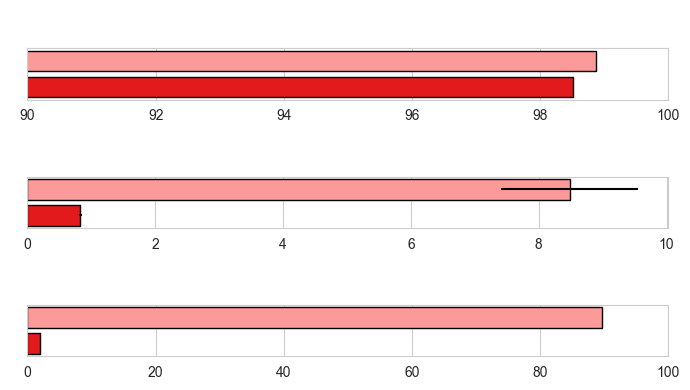

0.9963968433941164
10.26013678065189
44.54014564671982
{' ': ((98.86737823486328, 0), (8.483602261543275, 1.067001603440713), (89.71510696411133, 0)), '  ': ((98.51114358786994, 0), (0.8268507957458496, 0.02659636094489124), (2.0142526626586914, 0))}


In [26]:
def acc_lat_size(bars: dict[str, tuple]) -> None:
    sns.set_style("whitegrid")
    colors = sns.color_palette("Paired", 6)
    colors = [colors[5], colors[4]]

    labels     = list(bars.keys())

    accuracies = [bar[0] for bar in bars.values()]
    acc_val    = [v[0] for v in accuracies]
    acc_err    = [v[1] for v in accuracies]

    latencies = [bar[1] for bar in bars.values()]
    lat_val   = [v[0] for v in latencies]
    lat_err   = [v[1] for v in latencies]

    sizes   = [bar[2] for bar in bars.values()]
    siz_val = [v[0] for v in sizes]

    _, ax = plt.subplots(3, 1, figsize=(7, 4))

    ax[0].barh(labels[::-1], acc_val[::-1], edgecolor="black",  xerr=acc_err[::-1], color=colors)
    ax[0].set_xlim((90, 100))

    ax[1].barh(labels[::-1], lat_val[::-1], edgecolor="black", xerr=lat_err[::-1], color=colors)

    ax[2].barh(labels[::-1], siz_val[::-1], edgecolor="black", color=colors)
    ax[2].set_xlim((0, 100))

    ax[0].set_title(" ", fontsize=30)
    ax[1].set_title(" ", fontsize=30)
    ax[2].set_title(" ", fontsize=30)

    ax[0].grid(False, axis="y")
    ax[1].grid(False, axis="y")
    ax[2].grid(False, axis="y")

    plt.tight_layout()
    plt.show()


base_stats = get_model_stats_from_json("../model_stats.json", ["ResNet50 - Resolution 128"])[0]
optimized_stats = get_model_stats_from_json("../model_stats.json", ["ResNet50 - Resolution 128 - Full Optimization"])[0]

# Latencies precomputed from previous cell
base_latencies = [0.008223466396331787, 0.00725858998298645, 0.00834357500076294, 0.00933547592163086, 0.010543572425842286, 0.008992164373397827, 0.009689797401428222, 0.007468780755996704, 0.0077260141372680665, 0.007254586219787598]
optimized_latencies = [0.0008147401809692383, 0.0009008176326751711, 0.0008167414665222169, 0.0008157408237457274, 0.0008167417049407958, 0.0008477694988250732, 0.0008157405853271484, 0.0008167417049407958, 0.0008097352981567384, 0.0008137390613555907]

bars = dict()

bars[" "]  = (
    (base_stats.accuracy, 0), 
    (np.mean(base_latencies) * 1000, np.std(base_latencies) * 1000), 
    (get_model_size(base_stats.params, 32), 0)
)
bars["  "] = (
    (optimized_stats.accuracy, 0), 
    (np.mean(optimized_latencies) * 1000, np.std(optimized_latencies) * 1000), 
    (get_model_size(optimized_stats.params, 8), 0)
)

acc_lat_size(bars)

print(bars["  "][0][0] / bars[" "][0][0])
print(bars[" "][1][0] / bars["  "][1][0])
print(bars[" "][2][0] / bars["  "][2][0])
print(bars)

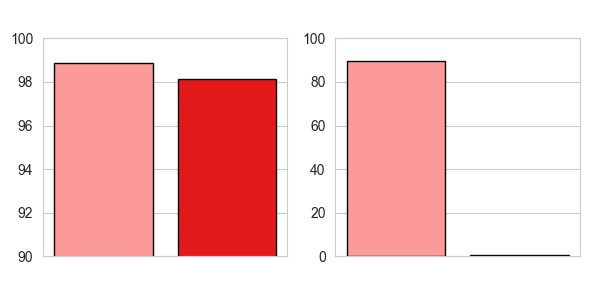

0.9925417438185564
199.39889377224935
460.72607421875


In [34]:
def acc_size(bars: dict[str, tuple]) -> None:
    sns.set_style("whitegrid")
    colors = sns.color_palette("Paired", 6)
    colors = [colors[4], colors[5]]

    labels     = list(bars.keys())

    accuracies = [bar[0] for bar in bars.values()]
    acc_val    = [v[0] for v in accuracies]
    acc_err    = [v[1] for v in accuracies]

    sizes   = [bar[1] for bar in bars.values()]
    siz_val = [v[0] for v in sizes]

    _, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].bar(labels, acc_val, edgecolor="black",  yerr=acc_err, color=colors)
    ax[0].set_ylim((90, 100))


    ax[1].bar(labels, siz_val, edgecolor="black", color=colors)
    ax[1].set_ylim((0, 100))

    ax[0].set_title(" ", fontsize=20)
    ax[1].set_title(" ", fontsize=20)

    ax[0].grid(False, axis="x")
    ax[1].grid(False, axis="x")

    plt.tight_layout()
    plt.show()


optimized_model_pruned_08 = load_model_from_pretrained(
    "resnet50", 
    "../Pretrained/ECG-Raw/Window-Shrinking/balance/ResNet50/resnet50_ep30_i128_r1.0/Pruned/resnet50_ep35_i128_p0.8_layer/resnet50_ep35_i128_p0.8_layer.pth",
    5, True
)
optimized_pruned_08_param = get_num_parameters(optimized_model_pruned_08)
optimized_pruned_08_size  = get_model_size(optimized_pruned_08_param, 4)

bars = dict()

bars[" "] = (
    (base_stats.accuracy, 0), 
    (get_model_size(base_stats.params, 32), 0)
)
bars["  "] = (
    (98.13, 0), 
    (optimized_pruned_08_size, 0)
)

acc_size(bars)

print(bars["  "][0][0] / bars[" "][0][0])
print(bars[" "][1][0] / bars["  "][1][0])
print(optimized_pruned_08_size * 1024)